In [ ]:
#data collection
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

In [ ]:
#data annotation
%matplotlib inline
from numpy import load

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = "/content/drive/MyDrive/dataset-week10/train/images/ZZPX50ICMLHT_jpg.rf.ebe48b11587bcb8c53a62e1136375308.jpg"
image = cv2.imread(image_path)

In [ ]:
print(image)

[[[ 2 26 72]
  [ 2 26 72]
  [ 2 25 71]
  ...
  [ 4  4  4]
  [ 4  4  4]
  [ 4  4  4]]

 [[ 2 26 72]
  [ 2 26 72]
  [ 2 25 71]
  ...
  [ 4  4  4]
  [ 4  4  4]
  [ 4  4  4]]

 [[ 2 26 72]
  [ 2 26 72]
  [ 2 25 71]
  ...
  [ 4  4  4]
  [ 4  4  4]
  [ 4  4  4]]

 ...

 [[19  5  6]
  [19  6  4]
  [21  6  3]
  ...
  [62  5  3]
  [62  5  3]
  [62  5  3]]

 [[20  7  9]
  [19  7  7]
  [19  6  4]
  ...
  [64  5  3]
  [64  5  3]
  [64  5  3]]

 [[19  8 10]
  [18  8  8]
  [20  7  5]
  ...
  [64  5  3]
  [64  5  3]
  [64  5  3]]]


In [ ]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

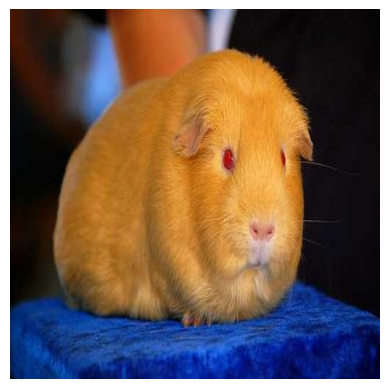

In [ ]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
#data preprocessing
import os
from sklearn.model_selection import train_test_split

train_dir = "/content/drive/MyDrive/dataset-week10/train/images/"
test_dir = "/content/drive/MyDrive/dataset-week10/test/images/"
valid_dir = "/content/drive/MyDrive/dataset-week10/valid/images/"

def preprocess_image(image_path, image_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    image = image / 255.0
    return image

def load_images_from_dir(directory, image_size):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            image = preprocess_image(image_path, image_size)
            images.append(image)
    return images

image_size = (224, 224)

train_images = load_images_from_dir(train_dir, image_size)
test_images = load_images_from_dir(test_dir, image_size)
valid_images = load_images_from_dir(valid_dir, image_size)

X_train, X_val = train_test_split(train_images, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
test_images = np.array(test_images)
valid_images = np.array(valid_images)

print("Training images shape:", X_train.shape)
print("Validation images shape:", X_val.shape)
print("Test images shape:", test_images.shape)
print("Validation images shape:", valid_images.shape)

Training images shape: (1077, 224, 224, 3)
Validation images shape: (270, 224, 224, 3)
Test images shape: (74, 224, 224, 3)
Validation images shape: (118, 224, 224, 3)


In [ ]:
#model selection
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

num_classes = 1

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 102MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for filename in os.listdir(self.root_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(self.root_dir, filename)
                images.append(img_path)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset_dir = "/content/drive/MyDrive/dataset-week10/train/images/"

custom_dataset = CustomDataset(dataset_dir, transform=transform)

data_loader = DataLoader(custom_dataset, batch_size=8, shuffle=True)

for images in data_loader:
    print(images.shape)


torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8,

In [ ]:
#model training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


num_classes = 10
model = CustomCNN(num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, optimizer, criterion, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, torch.zeros(images.size(0), dtype=torch.long, device=device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


num_epochs = 5
train_model(model, data_loader, optimizer, criterion, num_epochs)


Epoch 1/5, Loss: 0.0187
Epoch 2/5, Loss: 0.0000
Epoch 3/5, Loss: 0.0000
Epoch 4/5, Loss: 0.0000
Epoch 5/5, Loss: 0.0000


In [ ]:
# Evaluate the model
def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            outputs = model(images)
            total += images.size(0)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, torch.zeros(images.size(0), dtype=torch.long, device=device))
            total_loss += loss.item()
            correct += (predicted == 0).sum().item()
    val_loss = total_loss / len(val_loader)
    val_acc = correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')


In [ ]:
val_dataset_dir = "/content/drive/MyDrive/dataset-week10/valid/images/"

val_custom_dataset = CustomDataset(val_dataset_dir, transform=transform)

val_data_loader = DataLoader(val_custom_dataset, batch_size=8, shuffle=False)

evaluate_model(model, val_data_loader, criterion)

Validation Loss: 0.0000, Validation Accuracy: 1.0000
